In [1]:
# Python core
from typing import Union
from pathlib import Path

# Scientific python
import numpy as np
import xarray as xr
import dask

# Cloud compute
import gcsfs
import fsspec

In [2]:
BUCKET = Path('solar-pv-nowcasting-data')

# Satellite data
SAT_DATA_ZARR = BUCKET / 'satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16'

# Solar PV data
PV_PATH = BUCKET / 'PV/PVOutput.org'
PV_DATA_FILENAME = PV_PATH / 'UK_PV_timeseries_batch.nc'
PV_METADATA_FILENAME = PV_PATH / 'UK_PV_metadata.csv'

# Numerical weather predictions
NWP_ZARR = BUCKET / 'NWP/UK_Met_Office/UKV_zarr'

In [3]:
#client = await dask.distributed.Client(asynchronous=True, n_workers=12, memory_limit='32GB')
#client = dask.distributed.Client(n_workers=12, memory_limit='32GB')
#client = await dask.distributed.Client(asynchronous=True)
client = dask.distributed.Client(n_workers=16)
client

Client Scheduler: tcp://127.0.0.1:40533 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 102.19 GiB


In [4]:
#await client.shutdown()

In [ ]:
#client.shutdown()

In [6]:
def open_zarr_on_gcp(filename: Union[str, Path]=SAT_DATA_ZARR, consolidated: bool=True) -> xr.DataArray:
    """Lazily opens the Zarr store on Google Cloud Storage (GCS)."""
    # Clear reference to the loop and thread.  This is necessary otherwise
    # gcsfs hangs in the ML training loop.
    # See https://github.com/dask/gcsfs/issues/379#issuecomment-839929801
    # Only relevant for fsspec >= 0.9.0
    fsspec.asyn.iothread[0] = None
    fsspec.asyn.loop[0] = None
    
    gcs = gcsfs.GCSFileSystem(access='read_only')
    store = gcsfs.GCSMap(root=filename, gcs=gcs)
    dataset = xr.open_zarr(store, consolidated=consolidated)
    return dataset

In [7]:
def open_nwp(base_path: Path=NWP_ZARR) -> xr.Dataset:
    nwp_datasets = []
    for zarr_store in ['2018_1-6'] : #, '2018_7-12', '2019_1-6', '2019_7-12']:
        full_dir = base_path / zarr_store
        ds = open_zarr_on_gcp(full_dir)
        ds = ds.rename({'time': 'init_time'})
        # The isobaricInhPa coordinates look messed up, especially in the 2018_7-12 and 2019_7-12 Zarr stores.
        # So let's drop all the variables with multiple vertical levels for now:
        del ds['isobaricInhPa'], ds['gh_p'], ds['r_p'], ds['t_p'], ds['wdir_p'], ds['ws_p']
        nwp_datasets.append(ds)

    # Concat.
    dask.config.set({"array.slicing.split_large_chunks": False})  # Silence warning about large chunks
    nwp = xr.concat(nwp_datasets, dim='init_time')
    del nwp_datasets  # Save a little memory.
    
    # There are a lot of doubled-up indicies from 2018-07-18 00:00 to 2018-08-27 09:00.
    # De-duplicate the index. Code adapted from https://stackoverflow.com/a/51077784/732596
    _, unique_index = np.unique(nwp.init_time, return_index=True)
    return nwp.isel(init_time=unique_index)

In [8]:
ABSOLUTE_ZERO_CELSIUS = -273.15
MIN_TEMPERATURE_CELSIUS = -50
MAX_TEMPERATURE_CELSIUS = 50
RANGE_TEMPERATURE_CELSIUS = MAX_TEMPERATURE_CELSIUS - MIN_TEMPERATURE_CELSIUS

def temperature_kelvin_to_uint8(temperature_kelvin):
    temperature_celsius = temperature_kelvin + ABSOLUTE_ZERO_CELSIUS
    temperature_scaled_zero_to_one = (temperature_celsius - MIN_TEMPERATURE_CELSIUS) / RANGE_TEMPERATURE_CELSIUS
    temperature_8bit = (temperature_scaled_zero_to_one * 255).round().astype(np.uint8)
    return temperature_8bit

In [9]:
def rand_slice(lowest=0, highest=10, length=4):
    start = np.random.randint(
        low=lowest, 
        high=highest - length
    )
    end = start + length
    return slice(start, end)

rand_slice()

slice(5, 9, None)

In [10]:
%%time
nwp = open_nwp()

CPU times: user 1.59 s, sys: 106 ms, total: 1.69 s
Wall time: 1.94 s


In [11]:
%%time
temperature = temperature_kelvin_to_uint8(nwp['t']) # .chunk({"step": 1}))

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 9.38 ms


## Dask delayed and Dask futures

In [12]:
temperature

,Array,Chunk
Bytes,19.00 GiB,3.68 MiB
Shape,"(1429, 37, 704, 548)","(1, 10, 704, 548)"
Count,40013 Tasks,5716 Chunks
Type,uint8,numpy.ndarray


In [13]:
%%time
temperature_rechunked = temperature.chunk({'step': 1})

CPU times: user 436 ms, sys: 3.42 ms, total: 439 ms
Wall time: 430 ms


In [14]:
temperature_rechunked

,Array,Chunk
Bytes,19.00 GiB,376.75 kiB
Shape,"(1429, 37, 704, 548)","(1, 1, 704, 548)"
Count,145759 Tasks,52873 Chunks
Type,uint8,numpy.ndarray


In [15]:
def get_batch(slices, temperature):
    #nwp = open_nwp()
    #temperature = temperature_kelvin_to_uint8(nwp['t'])
    selected_nwps = []
    for slc in slices:
        selection = temperature.isel(init_time=slc, step=0)
        selected_nwps.append(selection)

    return dask.compute(selected_nwps)

In [21]:
slices = [rand_slice(highest=len(nwp.init_time)) for _ in range(5_000)]
slices[:5]

[slice(742, 746, None),
 slice(547, 551, None),
 slice(688, 692, None),
 slice(1186, 1190, None),
 slice(484, 488, None)]

In [22]:
%%time
#data = get_batch(slices, temperature)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [23]:
%%time
future = client.submit(get_batch, slices=slices, temperature=temperature_rechunked)

CPU times: user 200 ms, sys: 20.2 ms, total: 220 ms
Wall time: 215 ms


In [19]:
%%time
data = future.result()

CPU times: user 11.3 s, sys: 3.55 s, total: 14.8 s
Wall time: 28 s


In [20]:
del future

In [148]:
len(data[0])

1000

In [149]:
data[0][0]

<xarray.DataArray 't' (init_time: 4, y: 704, x: 548)>
array([[[140, 141, 141, ..., 135, 135, 132],
        [142, 142, 142, ..., 130, 129, 131],
        [143, 143, 143, ..., 123, 123, 128],
        ...,
        [155, 155, 155, ..., 145, 145, 145],
        [155, 155, 155, ..., 145, 145, 145],
        [155, 155, 155, ..., 145, 145, 145]],

       [[138, 139, 139, ..., 133, 134, 131],
        [138, 139, 139, ..., 129, 129, 131],
        [139, 139, 139, ..., 124, 124, 127],
        ...,
        [158, 158, 158, ..., 147, 147, 147],
        [158, 158, 158, ..., 147, 147, 147],
        [158, 158, 158, ..., 147, 147, 147]],

       [[144, 145, 145, ..., 134, 135, 132],
        [143, 144, 145, ..., 130, 130, 131],
        [143, 143, 144, ..., 122, 122, 127],
        ...,
        [158, 158, 158, ..., 143, 143, 143],
        [158, 158, 158, ..., 143, 143, 143],
        [158, 158, 158, ..., 144, 144, 144]],

       [[145, 145, 145, ..., 133, 134, 132],
        [145, 145, 145, ..., 129, 129, 132],
        [145, 145, 145, ..., 122, 122, 125],
        ...,
        [158, 158, 158, ..., 146, 146, 146],
        [158, 158, 158, ..., 146, 146, 146],
        [158, 158, 158, ..., 146, 146, 146]]], dtype=uint8)
Coordinates:
    step       timedelta64[ns] 00:00:00
  * init_time  (init_time) datetime64[ns] 2018-01-01T09:00:00 ... 2018-01-01T...
  * x          (x) float64 -2.38e+05 -2.36e+05 -2.34e+05 ... 8.54e+05 8.56e+05
  * y          (y) float64 1.222e+06 1.22e+06 1.218e+06 ... -1.82e+05 -1.84e+05

# Old experiments

## Dask.delayed, using local data

In [12]:
def get_slice(slc, data=temperature):
    return data.isel(init_time=slc, step=0)

In [110]:
def get_multiple_selections(n=100, data=temperature):
    selected_nwps = []
    for _ in range(n):
        slc = rand_slice(10)
        selected_nwps.append(get_slice(slc, data))
    return selected_nwps

In [56]:
%%time
selected_nwps = get_multiple_selections()

CPU times: user 674 ms, sys: 19.5 ms, total: 694 ms
Wall time: 681 ms


In [57]:
type(selected_nwps[0].data)

dask.array.core.Array

In [62]:
%%time
data = client.compute(selected_nwps)

/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/site-packages/distributed/worker.py:3593: UserWarning: Large object of size 14.96 MiB detected in task graph: 
  ([[[["('getitem-234ab398d146bdf52c46a456a808aead', ... a=np.ndarray>>)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


CPU times: user 33.4 s, sys: 1.42 s, total: 34.8 s
Wall time: 34.3 s


In [20]:
len(data)

100

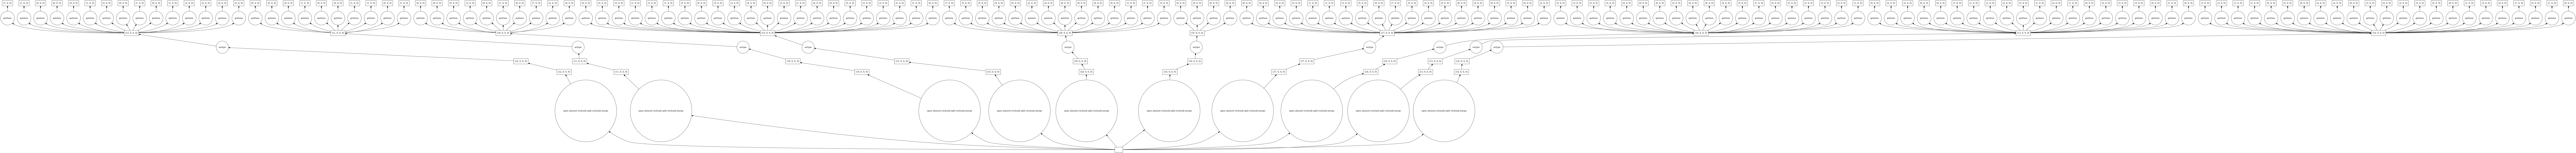

In [21]:
dask.visualize(selected_nwps, optimize_graph=True)

## Dask.delayed, opening data in the graph

In [31]:
@dask.delayed
def open_data():
    return open_nwp()

@dask.delayed
def process(data):
    return get_multiple_selections(data=data)

In [32]:
%%time
data = open_data()
data

CPU times: user 193 µs, sys: 25 µs, total: 218 µs
Wall time: 154 µs


Delayed('open_data-d7ec4f38-3fd3-4344-a8c7-68295fdb974f')

In [33]:
%%time
data = process(data)
data

CPU times: user 198 µs, sys: 0 ns, total: 198 µs
Wall time: 155 µs


Delayed('process-7528d408-73e8-4b0c-a9d3-3a3f4d2bacaf')

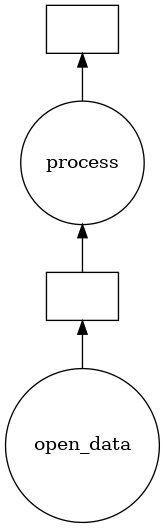

In [34]:
dask.visualize(data, optimize_graph=True)

In [35]:
%%time
future = client.submit(data)
future

CPU times: user 621 ms, sys: 47.9 ms, total: 668 ms
Wall time: 659 ms


<Future: pending, key: Delayed('process-7528d408-73e8-4b0c-a9d3-3a3f4d2ba-01e9e36bf5b71bb26373b7407f88f9ce>

In [37]:
%%time
data = future.result()
data

CPU times: user 631 ms, sys: 74.3 ms, total: 706 ms
Wall time: 1.22 s


Delayed('apply-959b9d8a-9b68-447e-8fee-269f1797fe28')

In [ ]:
%%time
data2 = data.compute()

## Dask Futures

In [63]:
%%time
future_nwp = client.submit(open_nwp)

CPU times: user 5.81 ms, sys: 184 µs, total: 5.99 ms
Wall time: 5.38 ms


In [67]:
def select_temperature_and_rechunk(nwp):
    return nwp['t'].chunk({"step": 1})

In [68]:
%%time
future_temperature = client.submit(select_temperature_and_rechunk, future_nwp)

In [69]:
%%time
future_temp_uint8 = client.submit(temperature_kelvin_to_uint8, future_temperature)

CPU times: user 2.09 ms, sys: 0 ns, total: 2.09 ms
Wall time: 1.94 ms


In [73]:
future_temp_uint8

<Future: finished, type: xarray.DataArray, key: temperature_kelvin_to_uint8-33ea250855e8ae8e59490ee310b4474e>

In [109]:
%%time
future_slices = []
for _ in range(100):
    future_slice = client.submit(xr.DataArray.isel, future_temp_uint8, init_time=rand_slice())
    future_slice = client.submit(xr.DataArray.persist, future_slice)
    future_slices.append(future_slice)

AssertionError: 

In [106]:
%%time
future_slices[1].result()

CPU times: user 4.56 ms, sys: 3.76 ms, total: 8.32 ms
Wall time: 7.75 ms


,Array,Chunk
Bytes,13.61 MiB,376.75 kiB
Shape,"(1, 37, 704, 548)","(1, 1, 704, 548)"
Count,37 Tasks,37 Chunks
Type,uint8,numpy.ndarray


In [107]:
%%time
data = client.gather(future_slices)

CPU times: user 1.68 s, sys: 27 ms, total: 1.71 s
Wall time: 1.69 s


In [96]:
len(data)

10